In [1]:
import pandas as pd
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import random
import scipy as sp
 
from math import sqrt, exp
from scipy.stats import norm
from pylab import plot, show, grid, xlabel, ylabel

## Simulation of Bitcoin Prices and LTV Ratios

In [2]:
# function for simulation of BTC and LTV volatility
def btc_sim(s0, ltv0, w, n, dt, sigma, mu, out_btc=None, out_ltv=None):
    s0 = np.asarray(s0)
    ltv0 = np.asarray(ltv0)
    
    # For each element of s0, generate a sample of n numbers from a
    # standard normal distribution.
    #z = norm.rvs(size=s0.shape + (n,), loc=0.0, scale=1.0)
    
    if out_btc is None:
        out_btc = np.empty(w.shape)
    
    if out_ltv is None:
        out_ltv = np.empty(w.shape)
    
    incr_s = np.exp(sigma*np.sqrt(dt)*w + (mu - (sigma**2)/2)*dt)
    incr_ltv = np.exp(-sigma*np.sqrt(dt)*w + (-mu + sigma**2-(sigma**2)/2)*dt)
    
    np.cumprod(incr_s, axis=-1, out=out_btc)
    np.cumprod(incr_ltv, axis=-1, out=out_ltv)
    
    out_btc *= np.expand_dims(s0, axis=-1)
    out_ltv *= np.expand_dims(ltv0, axis=-1)

    return out_btc, out_ltv

In [3]:
# simulation parameters
T = 12.0
N = 365  
dt = 1/N

t = np.linspace(0.0, T, N+1)

# number of realizations
m = 10000

#bitcoin value on 12/06/2020
S0 = 9425.92
LTV0 = 0.6

K = 0.9
D = 0.8

S = np.empty((m,N+1))
S[:,0] = S0

LTV = np.empty((m,N+1))
LTV[:,0] = LTV0

### Simulation with Volatility Jumps

In [4]:
# parameters for stochastic volatility jumps (estimated from BTC daily returns)
mu      = 0.041
#r       = mu
mu_y    = -0.084
sigma_y = 2.155
l       = 0.041
alpha   = 0.01
beta    = -0.132
rho     = 0.407
sigma_v = 0.008
rho_j   = -0.573
mu_v    = 0.62
v0      = 0.19**2
#v0 = sigma
kappa   = 1-beta
theta   = alpha / kappa

In [5]:
np.random.seed(202006)
w      = npr.standard_normal([m,N])
w2     = rho * w + sp.sqrt(1-rho**2) * npr.standard_normal([m,N])
z_v    = npr.exponential(mu_v, [m,N])
z_y    = npr.standard_normal([m,N]) * sigma_y + mu_y + rho_j * z_v
dj     = npr.binomial(1, l * dt, size=[m,N])
s      = np.zeros([m,N+1])
v      = np.zeros([m,N+1])

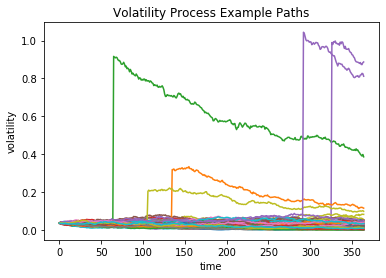

In [6]:
# volatility process
v = np.empty((m,N))
v[:,0] = v0
for i in range(1,N):
    v[:,i] = v[:,i-1] + kappa * (theta - np.maximum(0,v[:,i-1])) * dt + sigma_v * sp.sqrt(np.maximum(0,v[:,i-1])) * w2[:,i-1] + z_v[:,i-1] * dj[:,i-1]
    
# example paths
for k in range(100):
    plot(v[k])
    xlabel('time')
    ylabel('volatility')
    plt.title('Volatility Process Example Paths')
    plt.savefig('volapath.png', transparent=True)

In [7]:
# BTC and LTV simulation with jumps
S = np.empty((m,N+1))
S[:,0] = S0

LTV = np.empty((m,N+1))
LTV[:,0] = LTV0

npr.seed(202006)
btc_sim(S[:,0], LTV[:,0], w, N, dt, v, mu,
        out_btc=S[:,1:], out_ltv=LTV[:,1:]);

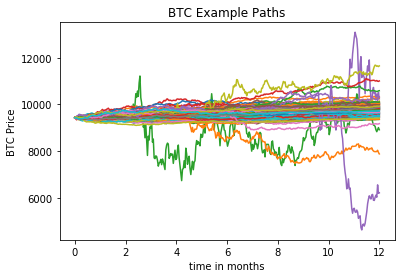

In [8]:
for k in range(100):    
    plot(t, S[k])
    xlabel('time in months')
    ylabel('BTC Price')
    plt.title('BTC Example Paths')

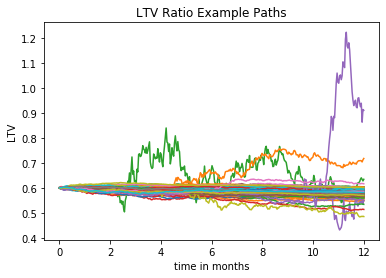

In [9]:
for k in range(100):    
    plot(t, LTV[k])
    xlabel('time in months')
    ylabel('LTV')
    plt.title('LTV Ratio Example Paths')

In [10]:
y=np.argwhere(LTV>=0.9)
y[np.argwhere(y[:,1:]<=100)];

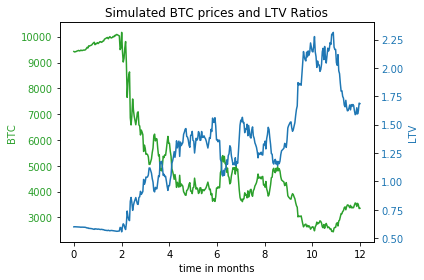

In [11]:
fig, ax1 = plt.subplots()

color = 'tab:green'
ax1.set_xlabel('time in months')
ax1.set_ylabel('BTC', color=color)
ax1.plot(t, S[220], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('LTV', color=color)  
ax2.plot(t, LTV[220], color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.axhline(y=1.5, color='r', linestyle='-')

plt.title('Simulated BTC prices and LTV Ratios')
fig.tight_layout() 
#plt.savefig('plots\\sim_2.png', transparent=True)
plt.show()

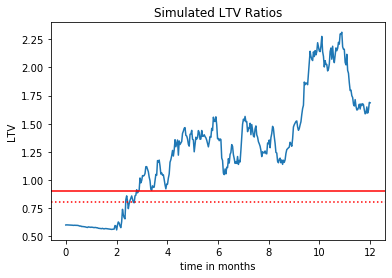

In [12]:
plot(t, LTV[220])

xlabel('time in months')
ylabel('LTV')
plt.title('Simulated LTV Ratios')
plt.axhline(y=K, color='r', linestyle='-')
plt.axhline(y=0.8, color='r', linestyle='dotted')
#plt.savefig('plots\\sim_ltv.png', transparent=True)
#leg = plt.legend()
#grid(True)
show()

## Determine Value of Lending Contract

In [13]:
# function for calculating the payoff of each contract at time t
def payoff(S, LTV, B0, K, l, t, N, r, v=0):
    B = (1+l)*B0             # total repayment
    CS_usd = B0/LTV[v,0]     # collateral size
    CS_btc = CS_usd/S[v,0]   # amount of bitcoin needed
    
    # find time points where LTV hits threshold
    tau = np.argwhere(LTV[v] >= K)
    
    if len(tau) == 0:
        F = exp(-r*(N-t)/N)*B
        
    else:
        F = exp(-r*((tau[0]-t)/N))*(CS_btc*S[v,tau[0]])
        
    return F

In [14]:
### contract parameters ###
# borrowed amount in USD
B0 = 10000

# pre-agreed interest rate
z = 0.1

# repayment
B = B0*(1+z)

# annual discounting factor
r = 0.01

# time point of view (in days)
t = N
K = 0.9

In [15]:
# calculate payoff for all contracts
F = np.empty((m))

for k in range(m):
    F[k]=payoff(S, LTV, B0, K, z, t, N, r, k)

In [16]:
# empirical mean of all contracts
mean = 1/m*sum(F)

# empirical variance
variance = 1/m*(sum((F-mean)**2))
sd = sqrt(variance)

print('mean payoff: ', round(mean, 3), sep="")
print('variance: ', round(variance, 3), ' with standard deviation ', round(sd, 3), sep="" )

mean payoff: 10997.933
variance: 1363.89 with standard deviation 36.931


In [17]:
print('Minimal Payoff: ', min(F), sep="")
print('Maximal Payoff: ', max(F), sep="")

Minimal Payoff: 9254.309126202992
Maximal Payoff: 11142.545525466572


In [18]:
# which path gives maximum payoff
print(np.argwhere(F == max(F)))

# liquidization day of this particular path
np.argwhere(LTV[np.argwhere(F == max(F))] >= K)[0,2]

[[7076]]


106

In [19]:
gain = len(np.argwhere(F > B0*(1+z)))
loss = len(np.argwhere(F < B0))
print('Lender loses money in ', loss, ' cases, and earns in ', gain, ' cases.', sep="")

Lender loses money in 3 cases, and earns in 26 cases.


In [20]:
print(S[7076,106], S[7076,365])

6257.166492820379 2229.957286864569


In [21]:
# therefore, the expected value of the contract is
V = exp(-r)*mean

# discounted value of the pre-agreed payback
b = exp(-r)*B

print('V = ', round(V, 2), sep="")
print('b = ', round(b, 2), sep="")

V = 10888.5
b = 10890.55
